# Best Practices to capture faces

The models used for face comparison operations are designed to work for a wide variety of poses, facial expressions, age ranges, rotations, lighting conditions, and sizes. We recommend that you use the following guidelines when choosing reference photos for CompareFaces or for adding faces to a collection using IndexFaces.

Use an image with a face that is within the recommended range of angles. The pitch should be less than 30 degrees face down and less than 45 degrees face up. The yaw should be less than 45 degrees in either direction. There is no restriction on the roll.

Use an image of a face with both eyes open and visible.

When creating a collection using IndexFaces, use multiple face images of an individual with different pitches and yaws (within the recommended range of angles). We recommend that at least five images of the person are indexed—straight on, face turned left with a yaw of 45 degrees or less, face turned right with a yaw of 45 degrees or less, face tilted down with a pitch of 30 degrees or less, and face tilted up with a pitch of 45 degrees or less. If you want to track that these face instances belong to the same individual, consider using the external image ID attribute if there is only one face in the image being indexed. For example, five images of John Doe can be tracked in the collection with external image IDs as John_Doe_1.jpg, … John_Doe_5.jpg.

Use an image of a face that is not obscured or tightly cropped. The image should contain the full head and shoulders of the person. It should not be cropped to the face bounding box.

Avoid items that block the face, such as headbands and masks.

Ensure face size is greater than 50x50 pixels

Use color images.

Use images with flat lighting on the face, as opposed to varied lighting such as shadows.

Use images that have sufficient contrast with the background. A high-contrast monochrome background works well.

Use images of faces with neutral facial expressions with mouth closed and little to no smile for applications that require high precision.

Use images that are bright and sharp. Avoid using images that may be blurry due to subject and camera motion as much as possible. DetectFaces can be used to determine the brightness and sharpness of a face.

### To ensure high quality face images, it is recommended to run the following image_check and contrast check functions  before storing the faces to S3 or Rekognition collections.

In [41]:
import boto3
import json
from IPython.display import Image as IImage
from PIL import Image
from skimage.exposure import is_low_contrast
import cv2

In [42]:
client=boto3.client('rekognition')

In [43]:
def image_check (photo):
    
    with open(photo, 'rb') as image:
        response = client.detect_faces(Image={'Bytes': image.read()},Attributes=['ALL'])
    
    
    # get image details
    image = Image.open(photo)
    imgWidth, imgHeight = image.size 
    faceDetail = response['FaceDetails'][0]
    pitch = faceDetail['Pose']['Pitch']
    yaw = faceDetail['Pose']['Yaw']
    sunglasses = faceDetail['Sunglasses']['Value']
    box = faceDetail['BoundingBox']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']
    eyesOpen = faceDetail['EyesOpen']['Value']
    emotion = faceDetail['Emotions'][0]['Type']
    emotionConfidence = faceDetail['Emotions'][0]['Confidence']
    mouthOpen = faceDetail['MouthOpen']['Value']
    image_results = ""
    
    # image compliance checks
    if (width < 50) or (height < 50):
        image_results += f'Face dimensions should be > 50x50 pixels. They are {width:.1f} x {height:.1f}\n'
        
    if (abs(yaw) > 45):
        image_results += f'Yaw (side face rotation) should be less than 45 degrees. It is {abs(yaw)} \n'
        
    if ((pitch > 45)):
        image_results += f'Pitch (looking up) should be less than 45 degrees. It is {pitch} \n'
        
    if ((pitch < -30)):
        image_results += f'Pitch (looking down) should be less than 30 degrees. It is {pitch} \n'
               
    if not eyesOpen:
        image_results += f'Eyes are not open \n'
    
    if sunglasses:
        image_results += f'remove sunglasses \n'
    
    if (mouthOpen):
        image_results += f'Mouth should be closed \n'

    # image is compliant if nothing was added to image results
    if (not image_results):
        image_results = "Image is compliant"
        
        
    return image_results
        

In [44]:
def low_contrast_check (photo):
    image = cv2.imread(photo)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return is_low_contrast(gray, fraction_threshold=0.35)

## Examples of acceptable face profile

###  Capture 5 images at different face angles

### Front view with head and shoulder -

In [52]:
path = './media/'

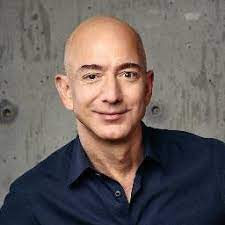

In [53]:
photo = path + 'bezos-frontface-shoulder-02.jpeg'
IImage(filename=photo)

In [54]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')

Image is compliant
Image has Good contrast


### Right side face profile with head and shoulder

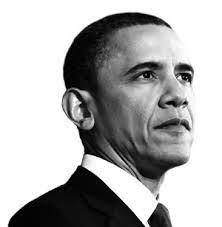

In [55]:
photo = path + 'obama-sideface-left.jpeg'
IImage(filename=photo) 


In [56]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')

Image is compliant
Image has Good contrast


### Left side face profile with head and shoulder

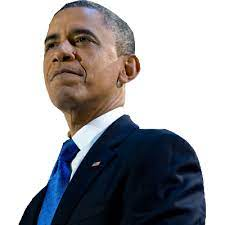

In [57]:
photo = path + 'obama-sideface-right.jpeg'
IImage(filename=photo)

In [58]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')

Image is compliant
Image has Good contrast


### Face turned up slightly with head and shoulder

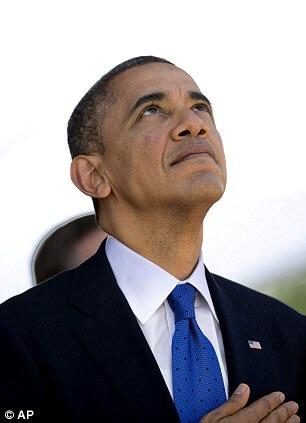

In [59]:
photo = path + 'obama-looking-up.jpeg'
IImage(filename=photo)

In [60]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')

Image is compliant
Image has Good contrast


### Face turned down slightly with head and shoulder

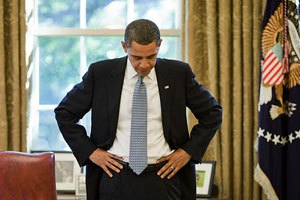

In [61]:
photo = path + 'obama-lookingdown.jpeg'
IImage(filename=photo)

In [62]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')

Face dimensions should be > 50x50 pixels. They are 31.6 x 37.7
Pitch (looking down) should be less than 30 degrees. It is -42.58332443237305 

Image has Good contrast


## Examples of unacceptable face profile - Examples with high yaw and pitch

In [63]:
photo = path + 'bezos-faceextremeleft.jpeg'

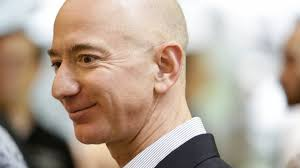

In [64]:
IImage(filename=photo) 

In [65]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Yaw (side face rotation) should be less than 45 degrees. It is 49.14448928833008 
Mouth should be closed 

Image has Good contrast


In [66]:
photo = path + 'bezos-faceextremeright.jpeg'

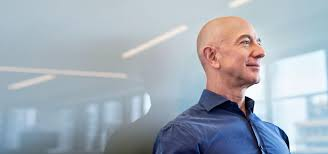

In [67]:
IImage(filename=photo)

In [68]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Face dimensions should be > 50x50 pixels. They are 45.1 x 63.1
Yaw (side face rotation) should be less than 45 degrees. It is 58.88406753540039 

Image has Good contrast


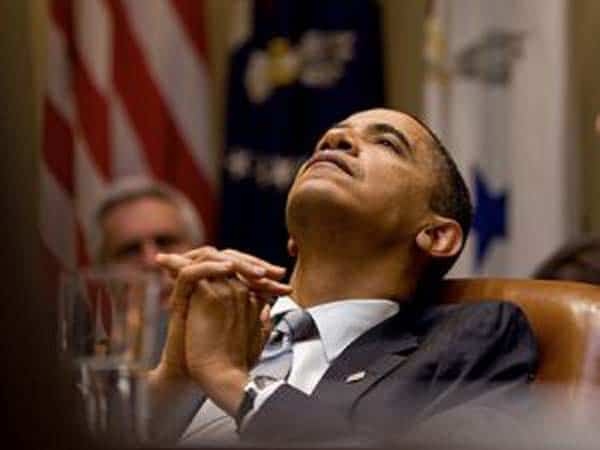

In [69]:
photo = path + 'obama-lookingup.jpeg'
IImage(filename=photo) 

In [70]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Pitch (looking up) should be less than 45 degrees. It is 53.95633316040039 

Image has Good contrast


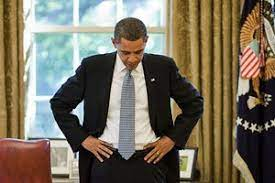

In [71]:
photo = path + 'obama-looking-down-high-pitch.jpeg'
IImage(filename=photo) 

In [72]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Face dimensions should be > 50x50 pixels. They are 28.3 x 33.5
Pitch (looking down) should be less than 30 degrees. It is -40.7339973449707 

Image has Good contrast


## Example of occlusions - Avoid sunglasses, masks, headbands, hat

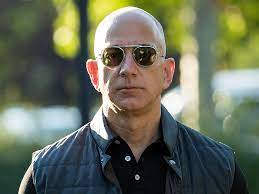

In [73]:
photo = path + 'bezos-sunglasses.jpeg'
IImage(filename=photo)

In [74]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


remove sunglasses 

Image has Good contrast


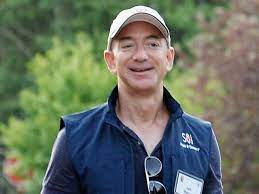

In [75]:
photo = path + 'bezos-hat.jpeg'
IImage(filename=photo) 

In [76]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Mouth should be closed 

Image has Good contrast


### Examples of low contrast images

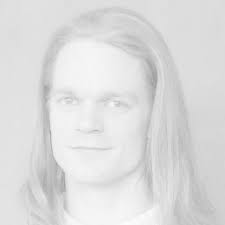

In [77]:
photo = path + 'man-lowcontrast.jpeg'
IImage(photo)

In [78]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')



Image is compliant
Image has Low contrast


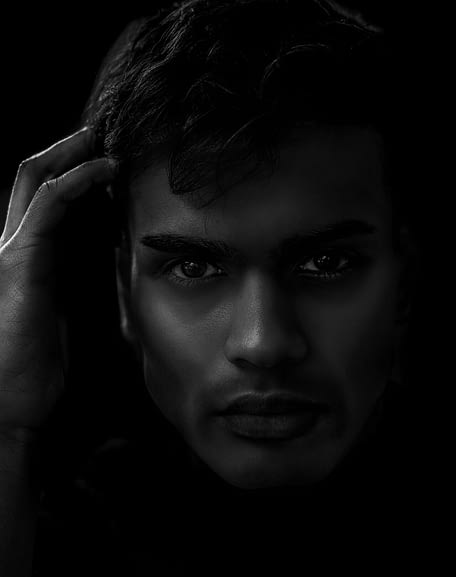

In [79]:
photo = path + 'man-darkcontrast.jpeg'
IImage(photo)

In [80]:
print(image_check(photo))
result = 'Good contrast' if not low_contrast_check (photo) else 'Low contrast'
print(f'Image has {result}')


Image is compliant
Image has Low contrast
